In [ ]:
import pickle
import numpy as np
import pandas as pd
import trimesh
import slam.io as sio
import nibabel as nib
from mne import read_epochs
from freesurfer_tools import transform_atlas, fsavg_vals_to_native
import matplotlib
matplotlib.use("Qt5Agg")
from matplotlib import cm, colors
import matplotlib.pylab as plt
import new_files
files = new_files.Files()
from sklearn.preprocessing import minmax_scale
from scipy.interpolate import interp2d, interp1d
from scipy.spatial.distance import euclidean
from scipy.signal import savgol_filter

In [122]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def csd_layer(data, mean_distance, n_surfs, nd=1):
    spacing = mean_distance*10*1e-3
    output_shape = data.shape
    csd = np.zeros(output_shape)
    for t in range(output_shape[1]):
        phi = data[:, t]
        csd[0, t] = data[0, t]
        csd[1, t] = data[1, t]
        for z in range(2, n_surfs-3):
            csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
        csd[-2, t] = data[-2, t]
        csd[-1, t] = data[-1, t]  
    return csd


def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [98]:
fils = files.get_files(
    "/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-002/",
    "*.csv", strings=["autoreject", "beh", "visual1"]
)

fils = [i for i in fils if files.check_many(["ses-03", "ses-04"], i, func="any")]

labels_sub2 = np.concatenate([pd.read_csv(i).trial_coherence.to_numpy() for i in fils])

In [ ]:
glasser = "/home/mszul/git/DANC_multilayer_laminar/assets/atlas_glasser_2016.csv"
dataset_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/"
fsavg_sphere_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.sphere.reg.gii",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.sphere.reg.gii"
]
annot_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.HCPMMP1.annot",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.HCPMMP1.annot"
]
thicc_l_paths = files.get_files("/home/mszul/git/DANC_multilayer_laminar/assets/big_brain_layer_thickness", "*.gii", strings=["hemi-L"], prefix="tpl-fsaverage")
thicc_r_paths = files.get_files("/home/mszul/git/DANC_multilayer_laminar/assets/big_brain_layer_thickness", "*.gii", strings=["hemi-R"], prefix="tpl-fsaverage")
thicc_lr_paths = list(zip(thicc_l_paths, thicc_r_paths))
subjects = ["sub-001", "sub-002"]
atlas = pd.read_csv(glasser)
target_labels = atlas[
    (atlas.PRIMARY_SECTION == 1) | 
    (atlas.USED_LABEL == "L_MT_ROI") | 
    (atlas.USED_LABEL == "R_MT_ROI")
].USED_LABEL.to_list()
print(target_labels)

In [29]:
e = read_epochs("/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-002/ses-01/autoreject-sub-002-ses-01-001-visual1-epo.fif", verbose=False)
times = e.times

In [ ]:
with open("brain_data.pickle", "rb") as f:
    brain_data = pickle.load(f)

In [116]:
brain_data['sub-001'].keys()

dict_keys(['mesh_colors', 'lab_col_map', 'ROI_maps', 'big_brain_prop_thickness', 'fsnat_wp_distance', 'pial__ds_inflated_path'])

In [120]:
brain_data[sub]["fsnat_wp_distance"][lab_vx_ix][peak_vx]

2.9701101779937744

In [ ]:
brain_data['sub-001']["fsnat_wp_distance"].shape

L_V1_ROI 725 (11, 529, 725, 601) 529
L_MT_ROI 39 (11, 529, 39, 601) 529
R_V1_ROI 699 (11, 529, 699, 601) 529
R_MT_ROI 48 (11, 529, 48, 601) 529
L_V1_ROI 495 (11, 1054, 495, 601) 1069
L_MT_ROI 12 (11, 1054, 12, 601) 1069
R_V1_ROI 528 (11, 1054, 528, 601) 1069
R_MT_ROI 35 (11, 1054, 35, 601) 1069


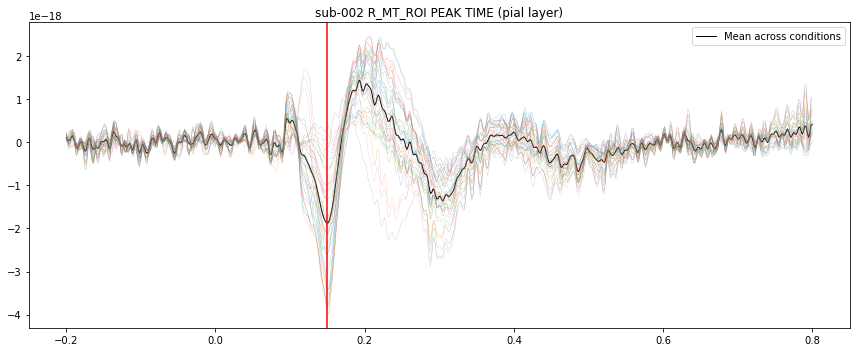

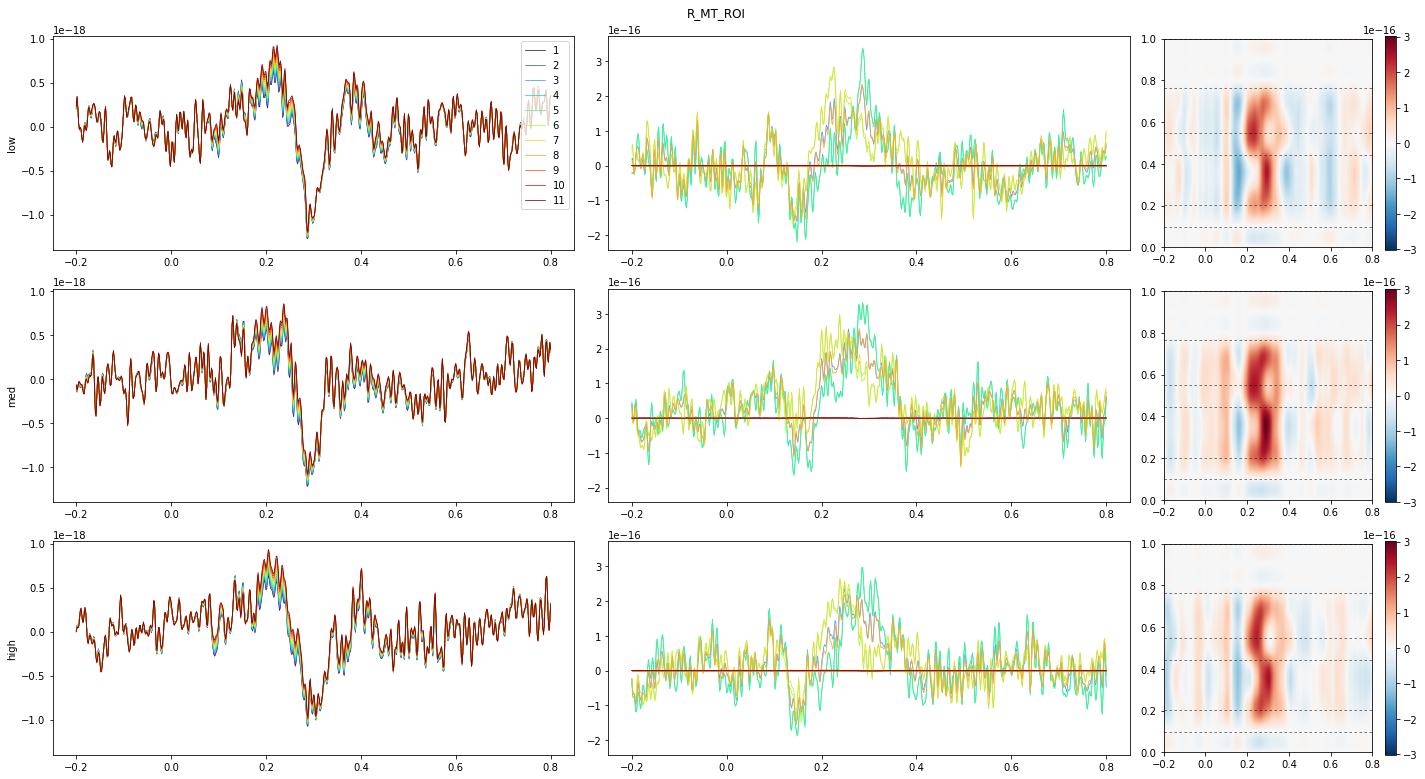

In [130]:
peak_map = {}
f, ax = plt.subplots(1, 1, figsize=(12,5), facecolor="white")

for sub in subjects:
    ROI_maps = brain_data[sub]["ROI_maps"]
    layers_prop_thickness = brain_data[sub]["big_brain_prop_thickness"]
    
    peak_map[sub] = {}
    for lab in target_labels:
        
        lab_vx_ix = np.arange(len(ROI_maps[lab]))[ROI_maps[lab]]
        layer_thiccness = []
        for lay in layers_prop_thickness.keys():
            layer_thiccness.append(layers_prop_thickness[lay][lab_vx_ix])
        layer_thiccness = np.array(layer_thiccness)
        mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
        fl = files.get_files(
            "/home/mszul/git/DANC_multilayer_laminar",
            "*.pickle", strings=[sub, lab], prefix="epoch"
        )[0]
        with open(fl, "rb") as f:
            epoch_data = pickle.load(f)
        # layers x epochs x vertices x time
        print(lab, np.sum(ROI_maps[lab]), epoch_data["epochs"].shape, len(epoch_data["labels"]))
        
        if sub == "sub-001":
            labels = epoch_data["labels"]
        else:
            labels = labels_sub2
        
        cond_masks = {}
        for con in np.unique(labels):
            cond_mask = np.array([i == con for i in labels])
            cond_masks[con] = cond_mask

        %matplotlib inline
        f, ax = plt.subplots(1, 1, figsize=(12,5), facecolor="white")
        cond_masks = {}
        for con in np.unique(labels):
            cond_mask = np.array([i == con for i in labels])
            cond_masks[con] = cond_mask

        epochs = epoch_data["epochs"]

        mean_pial_epochs = np.mean(epochs[-1], axis=0)
        mean_pial_vx = np.mean(mean_pial_epochs, axis=0)
        peak_time = np.argmax(np.abs(mean_pial_vx))
        peak_time_map = mean_pial_epochs[:,peak_time]
        peak_vx = np.argmax(peak_time_map)


        con_epochs_layers_means = {}
        for con in np.unique(labels):
            mean_pial_cond_vx = np.mean(epochs[-1][cond_masks[con]], axis=(0,1))
            con_epochs_layers_means[con] = np.mean(epochs[:, cond_masks[con]], axis=1)[:,peak_vx,:]

        ax.set_title("{} {} PEAK TIME (pial layer)".format(sub, lab))
        ax.plot(times, mean_pial_vx, label="Mean across conditions", lw=1, c="black")
        ax.plot(times, mean_pial_epochs.T, lw=0.3, alpha=0.5)
        ax.axvline(times[peak_time], c="red")
        ax.legend()
        plt.tight_layout()
        plt.savefig("/scratch/CSD_visualisations/PEAK_TIME_{}_{}.svg".format(sub, lab))

        distance = brain_data[sub]["fsnat_wp_distance"][lab_vx_ix][peak_vx]

        low_m, med_m, high_m = con_epochs_layers_means["low"], con_epochs_layers_means["med"], con_epochs_layers_means["high"]

        n_surfs = 11

        csd_low_m = compute_csd(low_m, times, distance, n_surfs)
        csd_med_m = compute_csd(med_m, times, distance, n_surfs)
        csd_high_m = compute_csd(high_m, times, distance, n_surfs)

        csd_smooth_low_m = smooth_csd(csd_low_m, n_surfs)
        csd_smooth_med_m = smooth_csd(csd_med_m, n_surfs)
        csd_smooth_high_m = smooth_csd(csd_high_m, n_surfs)

        all_epo = np.concatenate([low_m, med_m, high_m])
        all_csd = np.concatenate([csd_low_m, csd_med_m, csd_high_m])
        all_smooth = np.concatenate([csd_smooth_low_m, csd_smooth_med_m, csd_smooth_high_m])
        max_smooth = np.max(np.abs(all_smooth))
        mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
        f, ax = plt.subplots(3, 3, figsize=(20,11), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]}, facecolor="white",)
        f.suptitle(lab)
        ax[0,0].set_ylabel("low")
        ax[1,0].set_ylabel("med")
        ax[2,0].set_ylabel("high")
        for s in range(n_surfs):
            ax[0,0].plot(times, low_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[1,0].plot(times, med_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[2,0].plot(times, high_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[0,1].plot(times, csd_low_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[1,1].plot(times, csd_med_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[2,1].plot(times, csd_high_m[s], lw=0.75, c=colour_range[s], label=s+1)
            ax[0,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
            ax[1,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
            ax[2,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
            ax[0,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
            ax[1,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
            ax[2,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
        im = ax[0,2].imshow(csd_smooth_low_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
        cbar = plt.colorbar(im, ax=ax[0,2])
        ax[1,2].imshow(csd_smooth_med_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
        cbar = plt.colorbar(im, ax=ax[1,2])
        ax[2,2].imshow(csd_smooth_high_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
        cbar = plt.colorbar(im, ax=ax[2,2])
        for l_ix,th in enumerate(mean_ROI_thicc):
            l_ix = l_ix+1
            ax[0,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax[1,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            ax[2,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[0,0].legend()

        plt.tight_layout()
        plt.savefig("/scratch/CSD_visualisations/CSD_{}_{}.svg".format(sub, lab))

In [25]:
epoch_data["epochs"][-1].shape

(1054, 35, 601)

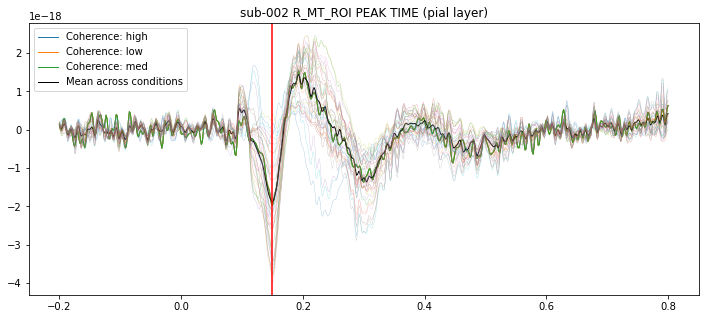

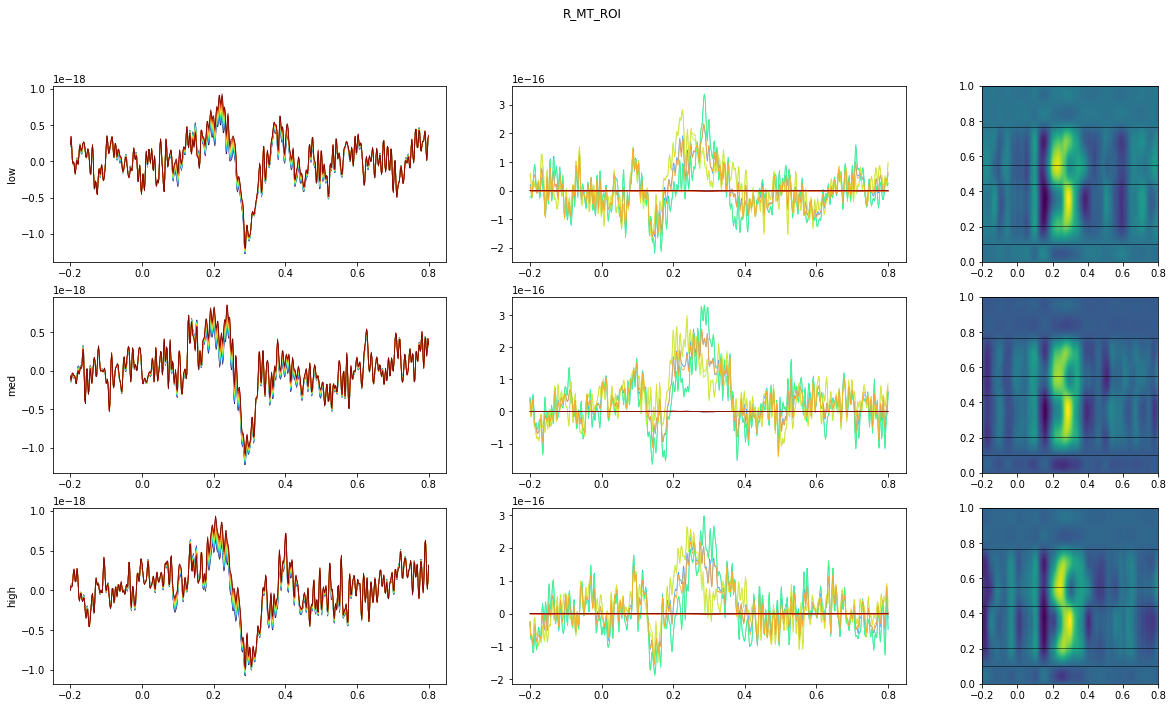

In [126]:
colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))
labels = labels_sub2

%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(12,5), facecolor="white")
cond_masks = {}
for con in np.unique(labels):
    cond_mask = np.array([i == con for i in labels])
    cond_masks[con] = cond_mask
    
epochs = epoch_data["epochs"]

mean_pial_epochs = np.mean(epochs[-1], axis=0)
mean_pial_vx = np.mean(mean_pial_epochs, axis=0)
peak_time = np.argmax(np.abs(mean_pial_vx))
peak_time_map = mean_pial_epochs[:,peak_time]
peak_vx = np.argmax(peak_time_map)


con_epochs_layers_means = {}
for con in np.unique(labels):
    mean_pial_cond_vx = np.mean(epochs[-1][cond_masks[con]], axis=(0,1))
    ax.plot(times, cond_vx, label="Coherence: {}".format(con), lw=1)
    con_epochs_layers_means[con] = np.mean(epochs[:, cond_masks[con]], axis=1)[:,peak_vx,:]

ax.set_title("{} {} PEAK TIME (pial layer)".format(sub, lab))
ax.plot(times, mean_pial_vx, label="Mean across conditions", lw=1, c="black")
ax.plot(times, mean_pial_epochs.T, lw=0.3, alpha=0.5)
ax.axvline(times[peak_time], c="red")
ax.legend()
plt.tight_layout()
plt.savefig("/scratch/CSD_visualisations/PEAK_TIME_{}_{}.svg".format(sub, lab))

distance = brain_data[sub]["fsnat_wp_distance"][lab_vx_ix][peak_vx]

low_m, med_m, high_m = con_epochs_layers_means["low"], con_epochs_layers_means["med"], con_epochs_layers_means["high"]

n_surfs = 11

csd_low_m = compute_csd(low_m, times, distance, n_surfs)
csd_med_m = compute_csd(med_m, times, distance, n_surfs)
csd_high_m = compute_csd(high_m, times, distance, n_surfs)

csd_smooth_low_m = smooth_csd(csd_low_m, n_surfs)
csd_smooth_med_m = smooth_csd(csd_med_m, n_surfs)
csd_smooth_high_m = smooth_csd(csd_high_m, n_surfs)

f, ax = plt.subplots(3, 3, figsize=(20,11), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]}, facecolor="white")
f.suptitle(lab)
ax[0,0].set_ylabel("low")
ax[1,0].set_ylabel("med")
ax[2,0].set_ylabel("high")
for s in range(n_surfs):
    ax[0,0].plot(times, low_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[1,0].plot(times, med_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[2,0].plot(times, high_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[0,1].plot(times, csd_low_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[1,1].plot(times, csd_med_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[2,1].plot(times, csd_high_m[s], lw=0.75, c=colour_range[s], label=s+1)
ax[0,2].imshow(csd_smooth_low_m, origin="lower", extent=[times[0], times[-1], 0, 1])
ax[1,2].imshow(csd_smooth_med_m, origin="lower", extent=[times[0], times[-1], 0, 1])
ax[2,2].imshow(csd_smooth_high_m, origin="lower", extent=[times[0], times[-1], 0, 1])
for l_ix,th in enumerate(mean_ROI_thicc):
    l_ix = l_ix+1
    ax[0,2].axhline(th, c="black", lw=0.5)
    ax[1,2].axhline(th, c="black", lw=0.5)
    ax[2,2].axhline(th, c="black", lw=0.5)
plt.tight_layout()
plt.savefig("/scratch/CSD_visualisations/CSD_{}_{}.svg".format(sub, lab))

In [115]:
np.mean(epochs[:, cond_masks[con]], axis=1)[:,peak_vx,:].shape

(11, 601)